
# Customer churn analysis

## 1. Initial data exploration
In this section, we perform an initial exploration of the dataset to understand its structure, identify missing values, and check data types.


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, roc_curve, auc,
                            precision_recall_curve)
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression

import shap
import joblib

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
file_path = file_path = "C:/Users/Robson/Downloads/churn_analysis_3M/Excel_Test_churn_dataset.xlsx"

# Check the names of the sheets in the Excel file
xls = pd.ExcelFile(file_path)
print(xls.sheet_names) 
print('*************************************************************************************************************')

# Reading the data from the specified sheet
df = pd.read_excel(file_path, sheet_name='churn_dataset')
print('Shape of the dataframe:')
print(df.shape) 
print('*************************************************************************************************************')
print('Information about missing values:')
print(df.isnull().sum().to_markdown())
print('*************************************************************************************************************')
print('Data Types of each column:')
print(df.dtypes.to_markdown())
print('*************************************************************************************************************')
print('Descriptive statistics for numerical columns:')
print(df.describe().to_markdown(numalign="left", stralign="left"))

['Challenge', 'Columns Description', 'churn_dataset']
*************************************************************************************************************
Shape of the dataframe:
(1500, 15)
*************************************************************************************************************
Information about missing values:
|                              |   0 |
|:-----------------------------|----:|
| customer_id                  |  94 |
| age                          |  96 |
| gender                       | 115 |
| subscription_type            |  96 |
| signup_date                  | 110 |
| last_active_date             |  99 |
| monthly_spend                |  93 |
| num_logins_last_month        |  91 |
| num_support_tickets          |  93 |
| is_auto_renew                | 103 |
| used_mobile_app              |  97 |
| num_referrals                | 118 |
| avg_session_duration_minutes | 113 |
| credit_score                 |  82 |
| churned                      | 

## 2. Descriptive Statistical Analysis and Handling of Missing Values

After the initial exploration, we handled the missing values and performed a more in-depth descriptive statistical analysis to understand the characteristics of the variables.

In [43]:
# Clipping outliers for specified numerical columns
# Using the 5th and 95th percentiles to clip outliers 
columns_to_clip = ['monthly_spend', 'avg_session_duration_minutes', 'credit_score']

for col in columns_to_clip:
    lower_limit = df[col].quantile(0.05)
    upper_limit = df[col].quantile(0.95)
    df[col] = df[col].clip(lower=lower_limit, upper=upper_limit)

# Fill missing values for numerical columns with the median
for col in ['age', 'monthly_spend', 'num_logins_last_month', 'num_support_tickets', 'is_auto_renew', 'used_mobile_app', 'num_referrals', 'avg_session_duration_minutes', 'credit_score']:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

# Fill missing values for categorical columns with the mode
for col in ['gender', 'subscription_type']:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])

# For customer_id, generate unique IDs for missing values
if df['customer_id'].isnull().any():
    missing_indices = df[df['customer_id'].isnull()].index
    df.loc[missing_indices, 'customer_id'] = ['CUST_MISSING_' + str(i) for i in missing_indices]

# Fill missing values for date columns with the median (date)
for col in ['signup_date', 'last_active_date']:
    if df[col].isnull().any():
        df[col] = df[col].fillna(pd.to_datetime(df[col].dropna().apply(lambda x: x.timestamp()).median(), unit='s'))
# Remove rows with target variable missing
df = df.dropna(subset=['churned'])
# Convert 'churned' to int, if not already
df['churned'] = df['churned'].astype(int)

print('Information about missing values after complete processing:')
print(df.isnull().sum().to_markdown())
print('*************************************************************************************************************')
print('Shape of the dataframe:')
print(df.shape) 
print('*************************************************************************************************************')
print('Descriptive statistics for numerical columns after processing:')
print(df.describe().to_markdown(numalign="left", stralign="left"))
print('*************************************************************************************************************')
print('Value counts for categorical columns:')
for col in ['gender', 'subscription_type', 'is_auto_renew', 'used_mobile_app', 'churned']:
    print(f'{col} ---')
    print(df[col].value_counts().to_markdown())


Information about missing values after complete processing:
|                              |   0 |
|:-----------------------------|----:|
| customer_id                  |   0 |
| age                          |   0 |
| gender                       |   0 |
| subscription_type            |   0 |
| signup_date                  |   0 |
| last_active_date             |   0 |
| monthly_spend                |   0 |
| num_logins_last_month        |   0 |
| num_support_tickets          |   0 |
| is_auto_renew                |   0 |
| used_mobile_app              |   0 |
| num_referrals                |   0 |
| avg_session_duration_minutes |   0 |
| credit_score                 |   0 |
| churned                      |   0 |
*************************************************************************************************************
Shape of the dataframe:
(1386, 15)
*************************************************************************************************************
Descriptive statistics


## 3. Churn Analysis and Pattern Identification

In this section, we analyze the distribution of churn and its relationship with other variables to identify potential patterns.

In [44]:
print('Churn Distribution:')
print(df['churned'].value_counts().to_markdown())
print(df['churned'].value_counts(normalize=True).to_markdown())

print('Churn by Gender:')
print(pd.crosstab(df['gender'], df['churned'], normalize='index').to_markdown())

print('Churn by Subscription Type:')
print(pd.crosstab(df['subscription_type'], df['churned'], normalize='index').to_markdown())

print('Churn by Auto-Renewal:')
print(pd.crosstab(df['is_auto_renew'], df['churned'], normalize='index').to_markdown())

print('Churn by Mobile App Usage:')
print(pd.crosstab(df['used_mobile_app'], df['churned'], normalize='index').to_markdown())

print('Correlation between Churn and Numerical Variables:')
print(df.corr(numeric_only=True)['churned'].sort_values(ascending=False).to_markdown())


Churn Distribution:
|   churned |   count |
|----------:|--------:|
|         0 |     728 |
|         1 |     658 |
|   churned |   proportion |
|----------:|-------------:|
|         0 |     0.525253 |
|         1 |     0.474747 |
Churn by Gender:
| gender   |        0 |        1 |
|:---------|---------:|---------:|
| Female   | 0.524138 | 0.475862 |
| Male     | 0.537893 | 0.462107 |
| Other    | 0.509756 | 0.490244 |
Churn by Subscription Type:
| subscription_type   |        0 |        1 |
|:--------------------|---------:|---------:|
| Basic               | 0.507177 | 0.492823 |
| Free                | 0.532847 | 0.467153 |
| Premium             | 0.533333 | 0.466667 |
Churn by Auto-Renewal:
|   is_auto_renew |        0 |        1 |
|----------------:|---------:|---------:|
|               0 | 0.513975 | 0.486025 |
|               1 | 0.53504  | 0.46496  |
Churn by Mobile App Usage:
|   used_mobile_app |        0 |        1 |
|------------------:|---------:|---------:|
|           


## 4. Visualizations and Insights

To complement the analysis, we generated visualizations to better understand the distribution of the variables and their relationship with churn.


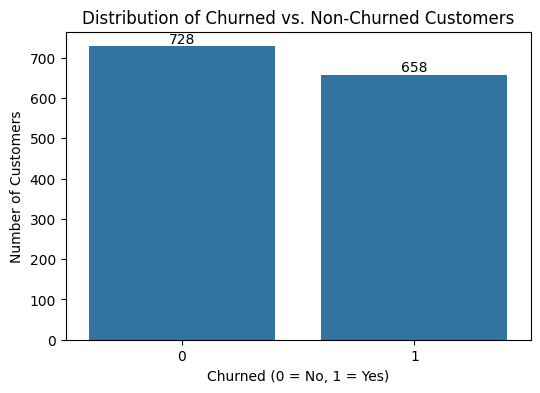

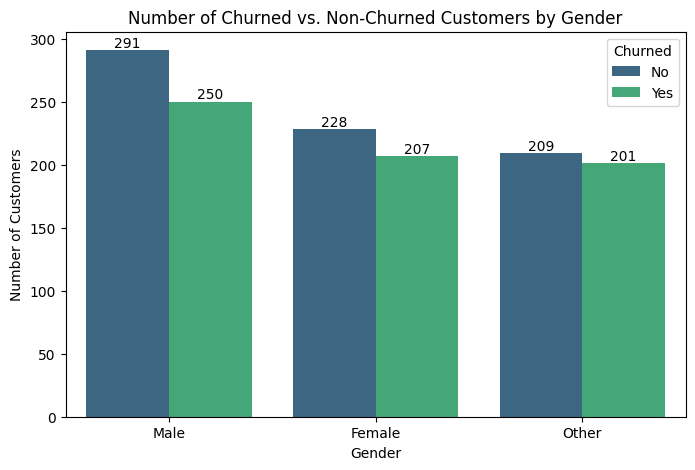

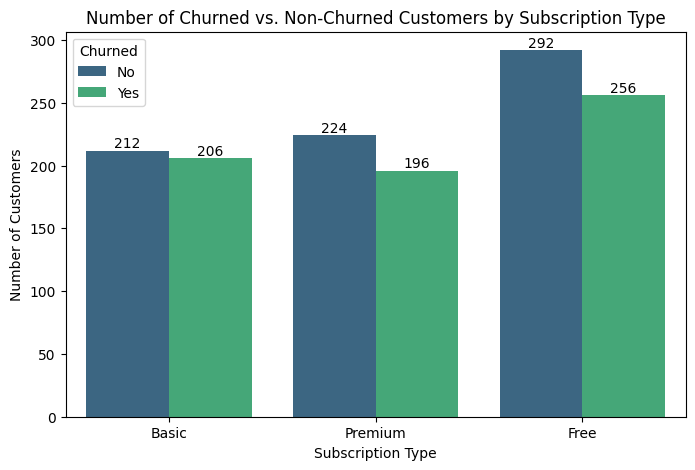

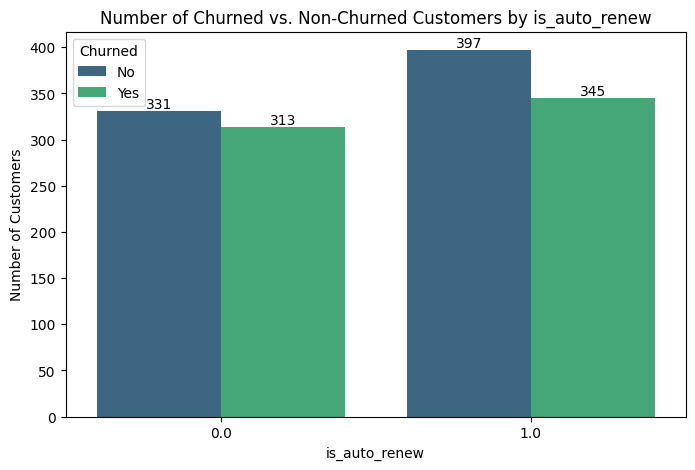

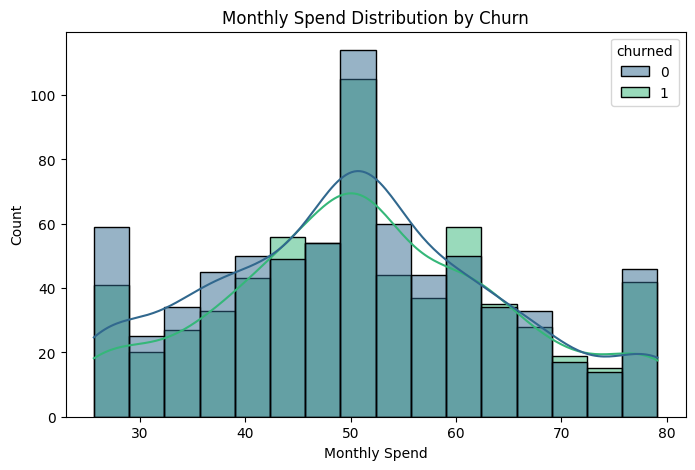

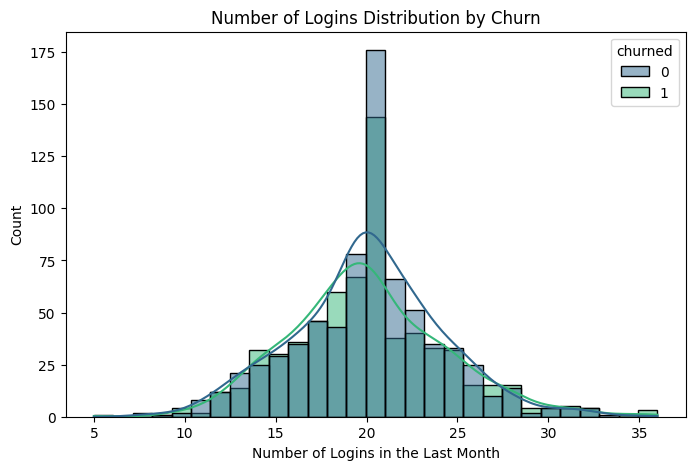

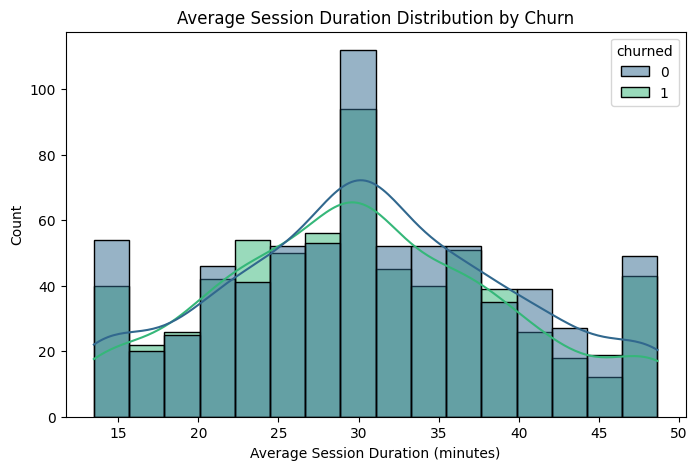

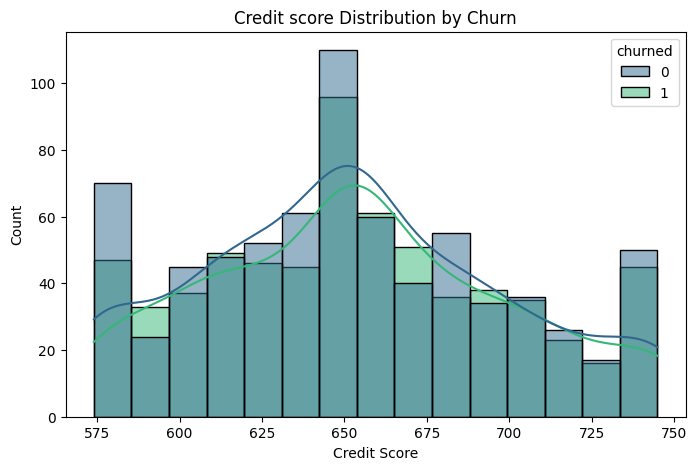

In [45]:
# 1. Churn Distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='churned', data=df)
plt.title('Distribution of Churned vs. Non-Churned Customers')
plt.xlabel('Churned (0 = No, 1 = Yes)')
plt.ylabel('Number of Customers')

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.show()

# 2. Churn by Gender
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='gender', hue='churned', data=df, palette='viridis')
plt.title('Number of Churned vs. Non-Churned Customers by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.legend(title='Churned', labels=['No', 'Yes'])

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.show()

# 3. Number of Churned vs. Non-Churned Customers by Subscription Type
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='subscription_type', hue='churned', data=df, palette='viridis')
plt.title('Number of Churned vs. Non-Churned Customers by Subscription Type')
plt.xlabel('Subscription Type')
plt.ylabel('Number of Customers')
plt.legend(title='Churned', labels=['No', 'Yes'])

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.show()

# 4. Number of Churned vs. Non-Churned Customers by Auto renewal
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='is_auto_renew', hue='churned', data=df, palette='viridis')
plt.title('Number of Churned vs. Non-Churned Customers by is_auto_renew')
plt.xlabel('is_auto_renew')
plt.ylabel('Number of Customers')
plt.legend(title='Churned', labels=['No', 'Yes'])

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

# 5. Monthly Spend Distribution by Churn
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='monthly_spend', hue='churned', kde=True, palette='viridis')
plt.title('Monthly Spend Distribution by Churn')
plt.xlabel('Monthly Spend')
plt.ylabel('Count')
plt.show()

# 6. Number of Logins Distribution by Churn
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='num_logins_last_month', hue='churned', kde=True, palette='viridis')
plt.title('Number of Logins Distribution by Churn')
plt.xlabel('Number of Logins in the Last Month')
plt.ylabel('Count')
plt.show()

# 7. Average Session Duration Distribution by Churn
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='avg_session_duration_minutes', hue='churned', kde=True, palette='viridis')
plt.title('Average Session Duration Distribution by Churn')
plt.xlabel('Average Session Duration (minutes)')
plt.ylabel('Count')
plt.show()

# 8. Average credit score Distribution by Churn
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='credit_score', hue='churned', kde=True, palette='viridis')
plt.title('Credit score Distribution by Churn')
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.show()

## 5. Feature engineering

Some features were created to improve the performance of the model

In [46]:
# Convert date columns to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_active_date'] = pd.to_datetime(df['last_active_date'])

# Current date for recency calculation
# This sets the 'current_date' to the latest 'last_active_date' found in the dataset.
# It's used as a reference point to calculate how recent user activity is.
current_date = df['last_active_date'].max()

# Feature Engineering
def create_features(df):
    # Temporal features
    # 'tenure_days': Calculates the number of days since the user signed up. 
    # It indicates how long a customer has been with the service.
    df['tenure_days'] = (current_date - df['signup_date']).dt.days
    
    # 'recency_days': Measures the number of days since the user's last activity. 
    # A higher value suggests the customer hasn't interacted recently, potentially indicating disengagement.
    df['recency_days'] = (current_date - df['last_active_date']).dt.days
    
    # 'activity_duration': Represents the total duration in days between a user's signup date and their last active date. 
    # Helps understand the overall period of active engagement.
    df['activity_duration'] = (df['last_active_date'] - df['signup_date']).dt.days
    
    # Engagement features
    # 'logins_per_day': Calculates the average number of logins per day over the last month. 
    # A key engagement metric; lower values may signal decreased interest.
    df['logins_per_day'] = df['num_logins_last_month'] / 30
    
    # 'ticket_frequency': Measures the number of support tickets raised per day since signup. 
    # Higher frequency might indicate problems or dissatisfaction.
    df['ticket_frequency'] = df['num_support_tickets'] / df['tenure_days']
    
    # Spending features
    # 'spend_per_login': Calculates monthly spending divided by the number of logins (plus one to avoid division by zero). 
    # Provides insight into monetary value generated per interaction.
    df['spend_per_login'] = df['monthly_spend'] / (df['num_logins_last_month'] + 1)
    
    # 'spend_per_day': Estimates the annualized spending converted to a daily average. 
    # Gives a standardized measure of a user's daily financial contribution.
    df['spend_per_day'] = df['monthly_spend'] * 12 / 365
    
    # Session features
    # 'total_session_time': Estimated total time spent in sessions, 
    # calculated by multiplying average session duration by the number of logins last month.
    df['total_session_time'] = df['avg_session_duration_minutes'] * df['num_logins_last_month']
    
    # Behavioral flags
    # 'low_engagement': Binary flag (0 or 1) indicating if the user had fewer than 15 logins in the last month. 
    # Identifies users showing signs of reduced interaction.
    df['low_engagement'] = (df['num_logins_last_month'] < 15).astype(int)
    
    # 'high_support': Binary flag indicating if the user has raised more than 3 support tickets. 
    # Designed to identify users experiencing significant issues, potentially a churn factor.
    df['high_support'] = (df['num_support_tickets'] > 3).astype(int)
    
    # Credit score bins
    # 'credit_score_group': Categorizes users into discrete groups based on their credit score. 
    # Helps capture non-linear relationships and different churn probabilities across score ranges.
    df['credit_score_group'] = pd.cut(df['credit_score'], 
                                      bins=[0, 580, 670, 740, 800, 900, 1200],
                                      labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent', 'Exceptional'])
    
    # Age groups
    # 'age_group': Categorizes users into predefined age ranges. 
    # Helps capture non-linear patterns related to age and churn, as different demographics may vary.
    df['age_group'] = pd.cut(df['age'], 
                             bins=[18, 30, 40, 50, 60, 70, 80, 100],
                             labels=['18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'])
    return df

df = create_features(df)

## 6. Modeling and Evaluation

The dataset is split into features and target variable, with the target being 'churned'. 
Different models are trained and evaluated using various metrics. 
The code includes hyperparameter tuning for the models, and the best model is selected based on cross-validation performance.

--- Starting Model Training and Evaluation ---

🔍 Training and evaluating model: Logistic Regression

   Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.62      0.61        73
           1       0.57      0.56      0.56        66

    accuracy                           0.59       139
   macro avg       0.59      0.59      0.59       139
weighted avg       0.59      0.59      0.59       139

   Confusion Matrix:
[[45 28]
 [29 37]]
   Accuracy: 0.5899
   Precision: 0.5692
   Recall: 0.5606
   F1 Score: 0.5649
   ROC AUC: 0.6216

🔍 Training and evaluating model: Random Forest

   Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.59      0.53        73
           1       0.40      0.30      0.34        66

    accuracy                           0.45       139
   macro avg       0.44      0.45      0.44       139
weighted avg       0.44      0.45      0.44       139

   Co

c:\Users\Robson\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:18:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Robson\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Robson\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



   Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.48      0.50        73
           1       0.46      0.50      0.48        66

    accuracy                           0.49       139
   macro avg       0.49      0.49      0.49       139
weighted avg       0.49      0.49      0.49       139

   Confusion Matrix:
[[35 38]
 [33 33]]
   Accuracy: 0.4892
   Precision: 0.4648
   Recall: 0.5000
   F1 Score: 0.4818
   ROC AUC: 0.5276

🔍 Training and evaluating model: CatBoost

   Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.52      0.51        73
           1       0.44      0.41      0.42        66

    accuracy                           0.47       139
   macro avg       0.46      0.46      0.46       139
weighted avg       0.47      0.47      0.47       139

   Confusion Matrix:
[[38 35]
 [39 27]]
   Accuracy: 0.4676
   Precision: 0.4355
   Recall: 0.4091
   F1 Score:

c:\Users\Robson\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


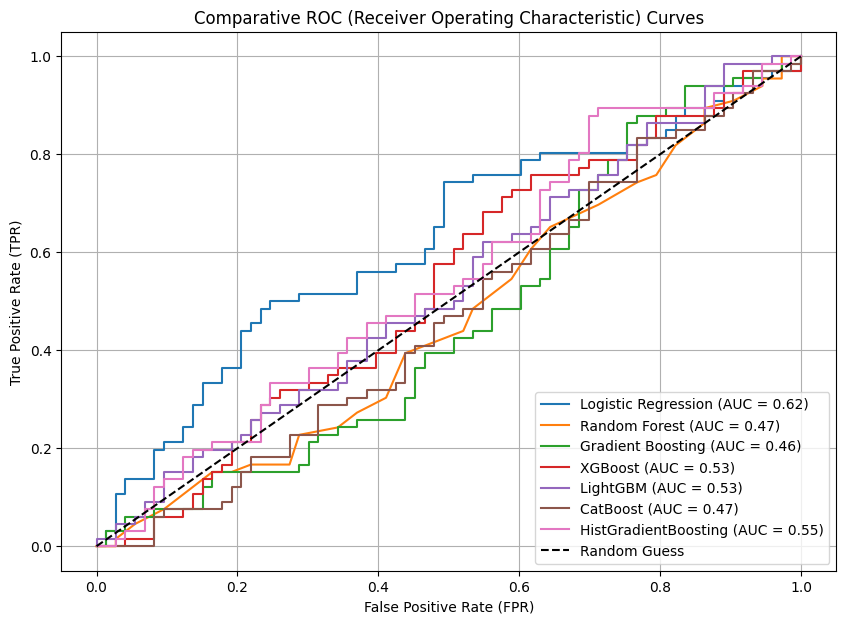

In [47]:
# Define features and target
X = df.drop(['churned', 'customer_id', 'signup_date', 'last_active_date','age'], axis=1)
y = df['churned']

# Identify feature types
categorical_features = ['gender', 'subscription_type', 'credit_score_group', 'age_group'] # Added 'payment_method' if it's categorical
numeric_features = [col for col in X.columns if col not in categorical_features]

# Preprocessing pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# --- Model Definitions ---
# Include all models for comparison
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42), # Added Random Forest
    "Gradient Boosting": GradientBoostingClassifier(random_state=42), # Your original model
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42)
}

# Dictionary to store performance results and trained pipelines
results = []
trained_pipelines = {}

print("--- Starting Model Training and Evaluation ---")
for name, clf in models.items():
    print(f"\n🔍 Training and evaluating model: {name}")
    
    # Create full modeling pipeline: preprocessing + model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    # Apply GridSearchCV specifically for Gradient Boosting as per your initial code
    if name == "Gradient Boosting":
        print("   Executing GridSearchCV for Gradient Boosting...")
        param_grid = {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__max_depth': [3, 5],
            'classifier__min_samples_leaf': [10, 20]
        }
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_pipeline = grid_search.best_estimator_
        print(f"   Best parameters for Gradient Boosting: {grid_search.best_params_}")
        print(f"   Best CV AUC for Gradient Boosting: {grid_search.best_score_:.4f}")
    else:
        pipeline.fit(X_train, y_train)
        best_pipeline = pipeline # For other models, the pipeline directly trained is the best

    trained_pipelines[name] = best_pipeline # Store the best pipeline for each model

    # Make predictions on the test set
    y_pred = best_pipeline.predict(X_test)
    y_proba = best_pipeline.predict_proba(X_test)[:, 1] if hasattr(best_pipeline.named_steps['classifier'], 'predict_proba') else None

    # Evaluate model performance using classification metrics
    print("\n   Classification Report:")
    print(classification_report(y_test, y_pred))

    print("   Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"   Accuracy: {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall: {rec:.4f}")
    print(f"   F1 Score: {f1:.4f}")
    print(f"   ROC AUC: {roc_auc:.4f}" if roc_auc else "   ROC AUC: Not available")

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

# Compare results in a DataFrame
results_df = pd.DataFrame(results)
print("\n--- 🔎 Model Comparison: ---")
print(results_df.sort_values(by='ROC AUC', ascending=False))

# --- Visualize ROC Curves for all Models ---
plt.figure(figsize=(10, 7))
for name, pipeline in trained_pipelines.items():
    if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Comparative ROC (Receiver Operating Characteristic) Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## 7. Model interpretation

The best performing model was choosed for interpratation using feature importance and shap


--- 📈 Interpretation for Model: Logistic Regression ---


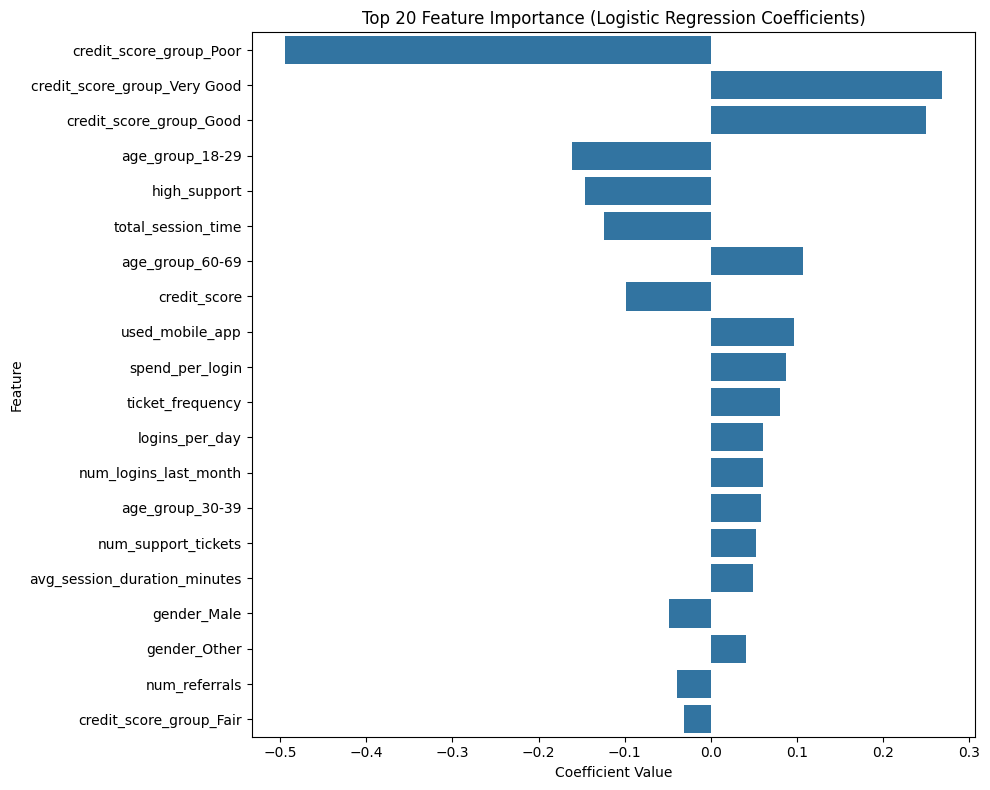


   SHAP Summary Plot (Bar) - Average Feature Impact:


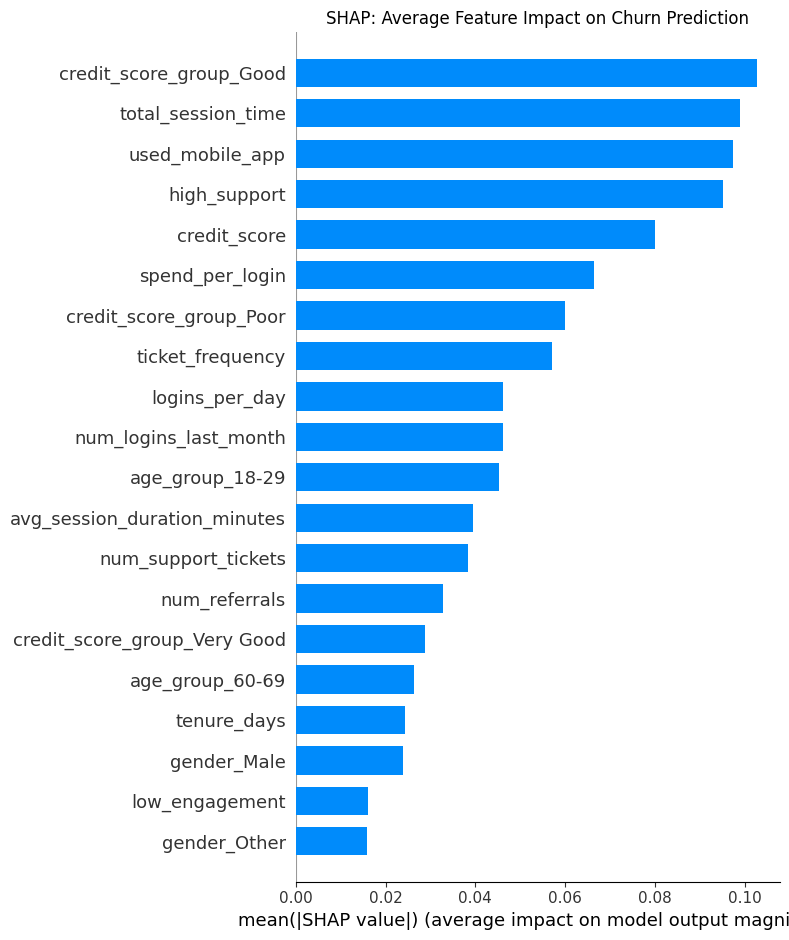


   SHAP Summary Plot (Beeswarm) - Feature Impact and Direction per Instance:


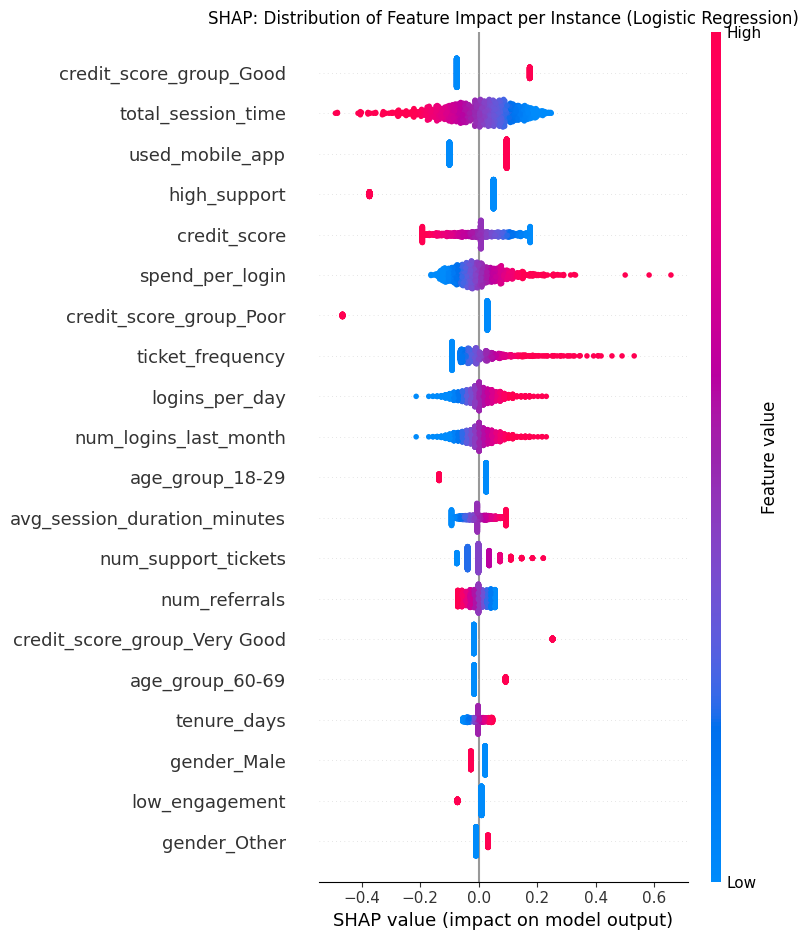


✅ The overall best performing model (based on ROC AUC), 'Logistic Regression', has been saved as 'churn_model_best_overall.pkl'.


In [48]:
# --- Interpretation for Logistic Regression
best_model_name = "Logistic Regression" # User specified Logistic Regression as the best
if best_model_name in trained_pipelines:
    lr_pipeline = trained_pipelines[best_model_name]
    print(f"\n--- 📈 Interpretation for Model: {best_model_name} ---")

    # Get feature names after one-hot encoding
    feature_encoder = lr_pipeline.named_steps['preprocessor']
    
    # Get the names of the processed numeric features
    processed_numeric_features = numeric_features
    
    # Get the names of the one-hot encoded categorical features
    # Use try-except for robustness in case 'cat' transformer is not present (though it should be)
    try:
        onehot_features = feature_encoder.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
        feature_names_encoded = list(processed_numeric_features) + list(onehot_features)
    except KeyError:
        print("Warning: Could not retrieve one-hot encoded feature names. SHAP plots might not have detailed labels.")
        feature_names_encoded = processed_numeric_features # Fallback if categorical isn't processed as expected
        # If no categorical features, this simplifies to numeric
        if not categorical_features:
            feature_names_encoded = numeric_features

    # Get the Logistic Regression classifier
    lr_classifier = lr_pipeline.named_steps['classifier']

    # --- Feature Importance using Coefficients for Logistic Regression ---
    # Coefficients directly reflect feature importance in linear models after scaling
    if hasattr(lr_classifier, 'coef_'):
        coefficients = lr_classifier.coef_[0] # For binary classification
        coef_df = pd.DataFrame({'Feature': feature_names_encoded, 'Coefficient': coefficients})
        coef_df['Absolute_Coefficient'] = coef_df['Coefficient'].abs()
        coef_df = coef_df.sort_values('Absolute_Coefficient', ascending=False).head(20)

        plt.figure(figsize=(10, 8))
        sns.barplot(x='Coefficient', y='Feature', data=coef_df)
        plt.title('Top 20 Feature Importance (Logistic Regression Coefficients)')
        plt.xlabel('Coefficient Value')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

    # --- SHAP Interpretation for Logistic Regression (Global Explainability) ---
    # Preprocess the training data for SHAP Explainer
    X_train_processed = feature_encoder.transform(X_train)

    # Use LinearExplainer for Logistic Regression
    explainer_lr = shap.LinearExplainer(lr_classifier, X_train_processed)
    shap_values_lr = explainer_lr.shap_values(X_train_processed)

    # SHAP Summary Plot (Bar)
    print("\n   SHAP Summary Plot (Bar) - Average Feature Impact:")
    shap.summary_plot(
        shap_values_lr,
        X_train_processed,
        feature_names=feature_names_encoded,
        plot_type="bar",
        max_display=20,
        show=False # Prevent immediate display to allow custom title/tight_layout
    )
    plt.title('SHAP: Average Feature Impact on Churn Prediction')
    plt.tight_layout()
    plt.show()

    # SHAP Summary Plot (Beeswarm - Dispersion)
    print("\n   SHAP Summary Plot (Beeswarm) - Feature Impact and Direction per Instance:")
    shap.summary_plot(
        shap_values_lr,
        X_train_processed,
        feature_names=feature_names_encoded,
        plot_type="dot", # This activates the beeswarm plot
        max_display=20,
        show=False
    )
    plt.title('SHAP: Distribution of Feature Impact per Instance (Logistic Regression)')
    plt.tight_layout()
    plt.show()
else:
    print(f"\nModel '{best_model_name}' not found in trained models. Interpretation plots could not be generated.")

# --- Save the best performing model (based on ROC AUC from comparison) ---
# This part saves the model that actually performed best according to the comparison

# Save the model that actually had the highest ROC AUC during the comparison
best_model_overall_name = results_df.sort_values(by='ROC AUC', ascending=False).iloc[0]['Model']
best_model_overall_pipeline = trained_pipelines[best_model_overall_name]
joblib.dump(best_model_overall_pipeline, 'churn_model_best_overall.pkl')
print(f"\n✅ The overall best performing model (based on ROC AUC), '{best_model_overall_name}', has been saved as 'churn_model_best_overall.pkl'.")
